### Tasks
1) Построить модель, прогнозирующую исход матча, т.е. выдать вероятность
победы домашней команды, вероятность ничьи и вероятность победы гостевой
команды.

2) Построить модель, прогнозирующую количество ударов. Спрогнозировать для
домашней и гостевой команд количество ударов в матче.
Описание данных:
- date - дата матча;
- championship - чемпионат;
- home_team - название домашней команды;
- away_team - название гостевой команды;
- home_goals - количество голов, которое забила домашняя команда;
- away_goals - количество голов, которое забила гостевая команда;
- home_shots - количество ударов по воротам соперника, которое нанесла
домашняя команда;
- away_shots - количество ударов по воротам соперника, которое нанесла
гостевая команда.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn import preprocessing
import lightgbm as lgb
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error, precision_score, accuracy_score
from sklearn.ensemble import GradientBoostingRegressor

In [2]:
df = pd.read_csv("data (1).csv")

In [3]:
df.describe()

,index,home_goals,away_goals,home_shots,away_shots
count,1903.0000,1903.000000,1903.000000,1903.000000,1903.000000
mean,951.0000,1.503941,1.240147,14.045717,11.714661
std,549.4931,1.274955,1.180202,5.450138,4.903381
min,0.0000,0.000000,0.000000,2.000000,1.000000
25%,475.5000,1.000000,0.000000,10.000000,8.000000
50%,951.0000,1.000000,1.000000,13.000000,11.000000
75%,1426.5000,2.000000,2.000000,17.000000,15.000000
max,1902.0000,10.000000,9.000000,45.000000,39.000000


In [4]:
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [5]:
missing_values_table(df)

Your selected dataframe has 9 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [6]:
df.dtypes

index            int64
date            object
championship    object
home_team       object
away_team       object
home_goals       int64
away_goals       int64
home_shots       int64
away_shots       int64
dtype: object

In [7]:
for name, col in df.iteritems():
    print(f'{name}: {col.nunique()}', "\n") 

index: 1903 

date: 1095 

championship: 6 

home_team: 114 

away_team: 114 

home_goals: 10 

away_goals: 9 

home_shots: 35 

away_shots: 31 



In [8]:
df["result"] = np.where(df["home_goals"] == df["away_goals"], "draw"
                        , np.where(df["home_goals"] > df["away_goals"], "domestic_win"
                        , np.where(df["home_goals"] < df["away_goals"], "away_win", np.nan)))  

pd.unique(df["result"])

array(['draw', 'away_win', 'domestic_win'], dtype=object)

In [9]:
df = pd.concat([df, pd.get_dummies(df["result"])], axis=1)

In [10]:
df.head(3)

,index,date,championship,home_team,away_team,home_goals,away_goals,home_shots,away_shots,result,away_win,domestic_win,draw
0,0,2019-08-03 14:00:00,Россия. ПЛ.,Урал,Ростов,2,2,14,21,draw,0,0,1
1,1,2019-08-03 16:30:00,Россия. ПЛ.,Крылья Советов,Локомотив М,1,2,10,20,away_win,1,0,0
2,2,2019-08-03 19:00:00,Россия. ПЛ.,Спартак М,Динамо М,0,0,12,25,draw,0,0,1


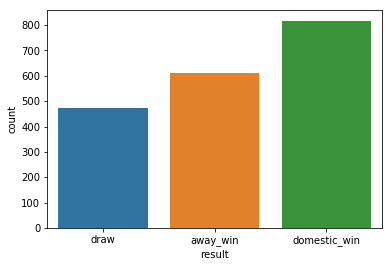

In [11]:
sns.countplot(df["result"])

In [12]:
# championships dates 
for i in pd.unique(df["championship"]):
    champ_data = df[df["championship"] == i]    
    print("size: ", len(champ_data), "\n"
          , "data_stat: ", {"min" : champ_data["date"].min()
                           , "max" : champ_data["date"].max()}
          , "\n"*2)

size:  206 
 data_stat:  {'min': '2019-08-03 14:00:00', 'max': '2020-07-22 19:00:00'} 


size:  380 
 data_stat:  {'min': '2019-08-09 20:00:00', 'max': '2020-07-26 18:00:00'} 


size:  279 
 data_stat:  {'min': '2019-08-09 21:45:00', 'max': '2020-03-08 23:00:00'} 


size:  299 
 data_stat:  {'min': '2019-08-16 19:30:00', 'max': '2020-06-27 14:30:00'} 


size:  369 
 data_stat:  {'min': '2019-08-16 22:00:00', 'max': '2020-07-19 22:00:00'} 


size:  370 
 data_stat:  {'min': '2019-08-24 17:00:00', 'max': '2020-07-29 22:45:00'} 




In [13]:
le = preprocessing.LabelEncoder()
df["target"] = le.fit_transform(df["result"])

### Generating common features for train and test
Преобразуем в дамми-переменные позже

In [14]:
df["team_combination"] = df["home_team"] + df["away_team"]
df["team_combination_invert"] = df["away_team"] + df["home_team"]

In [15]:
print(len(df), df["team_combination"].nunique()
      , len(set(df["team_combination"]).intersection(set(df["team_combination_invert"]))))

1903 1903 1742


In [16]:
adj = []
for i, j in zip(df["home_team"], df["away_team"]):
    champ = [i+"_vs_"+j , j+"_vs_"+i]
    champ = sorted(champ)
    del champ[1]
    adj.append(*champ)

df["adjusted_combination"] = adj


In [17]:
df["adjusted_combination"].nunique()

1032

In [18]:
del df["team_combination"], df["team_combination_invert"]

### Train-test split. 
Разделим табличку на тренировочное и тестовое множество. От каждого чемпионата возьмём первую половину матчей и запишем в train, остальное в test. Удалим всю информацию, известную на конец матча из тестового множества 

In [19]:
train = []
test = []
for i in pd.unique(df["championship"]):
    champ_data = df[df["championship"] == i]
    champ_data = champ_data.sort_values(by="date")
    split_percentage = 0.5
    split = int(split_percentage*len(champ_data))
    train.append(champ_data[:split])
    test.append(champ_data[split:])

train = pd.concat([i for i in train], axis=0)    
test =  pd.concat([i for i in test], axis=0)
del train["index"], test["index"]

In [20]:
train.head(3)

,date,championship,home_team,away_team,home_goals,away_goals,home_shots,away_shots,result,away_win,domestic_win,draw,target,adjusted_combination
0,2019-08-03 14:00:00,Россия. ПЛ.,Урал,Ростов,2,2,14,21,draw,0,0,1,2,Ростов _vs_Урал ...
1,2019-08-03 16:30:00,Россия. ПЛ.,Крылья Советов,Локомотив М,1,2,10,20,away_win,1,0,0,0,Крылья Советов _vs_Локомотив М
2,2019-08-03 19:00:00,Россия. ПЛ.,Спартак М,Динамо М,0,0,12,25,draw,0,0,1,2,Динамо М_vs_Спартак М


In [21]:
test.head(3)

,date,championship,home_team,away_team,home_goals,away_goals,home_shots,away_shots,result,away_win,domestic_win,draw,target,adjusted_combination
698,2019-11-23 16:30:00,Россия. ПЛ.,Динамо М,Ростов,2,1,12,14,domestic_win,0,1,0,1,Динамо М_vs_Ростов
712,2019-11-24 11:30:00,Россия. ПЛ.,Уфа,Сочи,1,1,16,13,draw,0,0,1,2,Сочи_vs_Уфа
716,2019-11-24 14:00:00,Россия. ПЛ.,Урал,Спартак М,0,0,11,21,draw,0,0,1,2,Спартак М_vs_Урал


### Feature Engineering
посчитаем статистики по командам

In [22]:
home = pd.DataFrame()
away = pd.DataFrame()
for i in pd.unique(pd.concat([train["home_team"], train["away_team"]], axis=0)):
    
    team_home_data = train[train["home_team"] == i]
    home_win_ratio = team_home_data["domestic_win"].sum() / len(team_home_data["domestic_win"])
    home_loss_ratio = team_home_data["away_win"].sum() / len(team_home_data["away_win"])
    home_draw_ratio = team_home_data["draw"].sum() / len(team_home_data["draw"])
    xg_home = team_home_data["home_goals"] / team_home_data["home_shots"]
    home_xg_min, home_xg_avg, home_xg_max = xg_home.min(), xg_home.mean(), xg_home.max()
    home_xg_total = team_home_data["home_goals"].sum() / team_home_data["home_shots"].sum()
    
    home_dct = {"team" : i, "home_win_ratio" : home_win_ratio, "home_loss_ratio" : home_loss_ratio
               , "home_draw_ratio" : home_draw_ratio, "home_xg_min" : home_xg_min
               , "home_xg_avg" : home_xg_avg, "home_xg_max" : home_xg_max
               , "home_xg_total" : home_xg_total}    
    
    home = home.append(home_dct, ignore_index=True)
    
    team_away_data = train[train["away_team"] == i]
    away_loss_ratio = team_away_data["domestic_win"].sum() / len(team_away_data["domestic_win"])
    away_win_ratio = team_away_data["away_win"].sum() / len(team_away_data["away_win"])
    away_draw_ratio = team_away_data["draw"].sum() / len(team_away_data["draw"])
    xg_away = team_away_data["away_goals"] / team_away_data["away_shots"]
    away_xg_min, away_xg_avg, away_xg_max = xg_away.min(), xg_away.mean(), xg_away.max()
    away_xg_total = team_away_data["away_goals"].sum() / team_away_data["away_shots"].sum()
    
    away_dct = {"team" : i, "away_win_ratio" : away_win_ratio, "away_loss_ratio" : away_loss_ratio
               , "away_draw_ratio" : away_draw_ratio, "away_xg_min" : away_xg_min
               , "away_xg_avg" : away_xg_avg, "away_xg_max" : away_xg_max
               , "away_xg_total" : away_xg_total}
    
    away = away.append(away_dct, ignore_index=True)

In [23]:
train = pd.merge(train, home, left_on="home_team", right_on="team", how = "left")
train = pd.merge(train, away, left_on="away_team", right_on="team", how = "left")

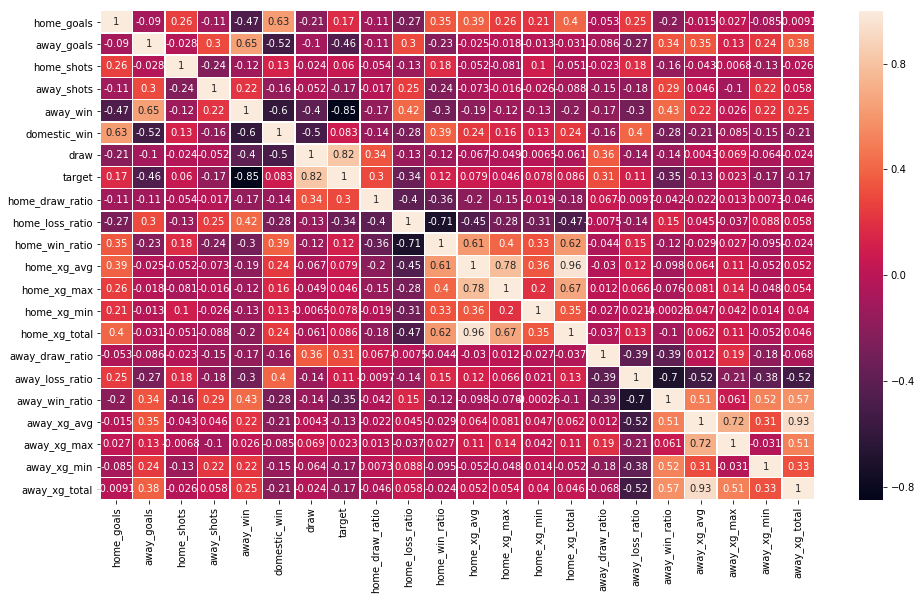

In [24]:
plt.figure(figsize = (16,9))
sns.heatmap(train.corr(), annot=True, linewidths=.5)

In [25]:
test = pd.merge(test, home, left_on="home_team", right_on="team", how = "left")
test = pd.merge(test, away, left_on="away_team", right_on="team", how = "left")

In [26]:
train.head(3)

,date,championship,home_team,away_team,home_goals,away_goals,home_shots,away_shots,result,away_win,...,home_xg_total,team_x,away_draw_ratio,away_loss_ratio,away_win_ratio,away_xg_avg,away_xg_max,away_xg_min,away_xg_total,team_y
0,2019-08-03 14:00:00,Россия. ПЛ.,Урал,Ростов,2,2,14,21,draw,0,...,0.098901,Урал,0.285714,0.428571,0.285714,0.150247,0.400000,0.00,0.113402,Ростов
1,2019-08-03 16:30:00,Россия. ПЛ.,Крылья Советов,Локомотив М,1,2,10,20,away_win,1,...,0.072727,Крылья Советов,0.250000,0.000000,0.750000,0.119142,0.250000,0.05,0.111940,Локомотив М
2,2019-08-03 19:00:00,Россия. ПЛ.,Спартак М,Динамо М,0,0,12,25,draw,0,...,0.046512,Спартак М,0.285714,0.285714,0.428571,0.051252,0.142857,0.00,0.041237,Динамо М


In [27]:
train.shape, test.shape

((950, 30), (953, 30))

In [28]:
train_task_2 = train.copy()
test_task_2 = test.copy()
task_2 = [train_task_2, test_task_2]

# Task 1

In [29]:
train.columns, test.columns

(Index(['date', 'championship', 'home_team', 'away_team', 'home_goals',
        'away_goals', 'home_shots', 'away_shots', 'result', 'away_win',
        'domestic_win', 'draw', 'target', 'adjusted_combination',
        'home_draw_ratio', 'home_loss_ratio', 'home_win_ratio', 'home_xg_avg',
        'home_xg_max', 'home_xg_min', 'home_xg_total', 'team_x',
        'away_draw_ratio', 'away_loss_ratio', 'away_win_ratio', 'away_xg_avg',
        'away_xg_max', 'away_xg_min', 'away_xg_total', 'team_y'],
       dtype='object'),
 Index(['date', 'championship', 'home_team', 'away_team', 'home_goals',
        'away_goals', 'home_shots', 'away_shots', 'result', 'away_win',
        'domestic_win', 'draw', 'target', 'adjusted_combination',
        'home_draw_ratio', 'home_loss_ratio', 'home_win_ratio', 'home_xg_avg',
        'home_xg_max', 'home_xg_min', 'home_xg_total', 'team_x',
        'away_draw_ratio', 'away_loss_ratio', 'away_win_ratio', 'away_xg_avg',
        'away_xg_max', 'away_xg_min', 'away_

In [30]:
del train["date"], train["home_goals"], train["away_goals"], train["home_shots"] \
, train["away_shots"], train["result"], train["away_win"], train["domestic_win"]\
, train["draw"], train["team_x"], train["team_y"] 

del test["date"], test["home_goals"], test["away_goals"], test["home_shots"]\
, test["away_shots"], test["result"], test["away_win"], test["domestic_win"]\
, test["draw"], test["team_x"], test["team_y"]

In [31]:
X_train, y_train, X_test, y_test = train, train["target"], test, test["target"] # тоже заредачить

In [32]:
X_train.shape, X_test.shape

((950, 19), (953, 19))

In [33]:
[i for i in X_test.columns if i not in X_train.columns]

[]

# LGB

In [34]:
def cat_to_int(train, test):
    mem_orig_train = train.memory_usage().sum() / 1024**2
    mem_orig_test  = test .memory_usage().sum() / 1024**2
    categorical_feats = [ f for f in train.columns if train[f].dtype == 'object' or train[f].dtype.name == 'category' ]
    print('---------------------')
    print(categorical_feats)
    for f_ in categorical_feats:
        train[f_], indexer = pd.factorize(train[f_])
        test[f_] = indexer.get_indexer(test[f_])
    print('Memory usage of train increases from {:.2f} to {:.2f} MB'.format(mem_orig_train, 
                                                                            train.memory_usage().sum() / 1024**2))
    print('Memory usage of test increases from {:.2f} to {:.2f} MB'.format(mem_orig_test, 
                                                                            test.memory_usage().sum() / 1024**2))
    return categorical_feats, train, test

categorical_feats, X_train, X_test = cat_to_int(X_train, X_test)

---------------------
['championship', 'home_team', 'away_team', 'adjusted_combination']
Memory usage of train increases from 0.14 to 0.14 MB
Memory usage of test increases from 0.14 to 0.14 MB


In [35]:
del X_train["target"], X_test["target"]

In [36]:
X_train.shape, X_test.shape

((950, 18), (953, 18))

In [37]:
def learning_rate_010_decay_power_099(current_iter):
    base_learning_rate = 0.1
    lr = base_learning_rate  * np.power(.99, current_iter)
    return lr if lr > 1e-3 else 1e-3

def learning_rate_010_decay_power_0995(current_iter):
    base_learning_rate = 0.1
    lr = base_learning_rate  * np.power(.995, current_iter)
    return lr if lr > 1e-3 else 1e-3

def learning_rate_005_decay_power_099(current_iter):
    base_learning_rate = 0.05
    lr = base_learning_rate  * np.power(.99, current_iter)
    return lr if lr > 1e-3 else 1e-3

In [38]:
fit_params={"early_stopping_rounds":200, 
            "eval_metric" : 'multi_logloss', 
            "eval_set" : [(X_test,y_test)],
            'eval_names': ['valid'],
            #'callbacks': [lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_099)],
            'verbose': 100,
            'categorical_feature': 'auto'}


param_test ={'num_leaves': sp_randint(6, 50), 
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

#This parameter defines the number of HP points to be tested
n_HP_points_to_test = 100

#n_estimators is set to a "large value". The actual number of trees build will depend on early stopping and 5000 define only the absolute maximum
clf = lgb.LGBMClassifier(max_depth=-1, random_state=314, silent=True, metric='None', \
                         n_jobs=4, n_estimators=5000, min_data_in_bin=1, min_data=1)
gs = RandomizedSearchCV(
    estimator=clf, param_distributions=param_test, 
    n_iter=n_HP_points_to_test,
    scoring='accuracy',
    cv=3,
    refit=True,
    random_state=314,
    verbose=True)

In [39]:
gs.fit(X_train, y_train, **fit_params)
print(f'Best score reached: {gs.best_score_} with params: {gs.best_params_} ')

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Training until validation scores don't improve for 200 rounds.
[100]	valid's multi_logloss: 1.13296


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[200]	valid's multi_logloss: 1.2102
Early stopping, best iteration is:
[18]	valid's multi_logloss: 1.06061
Training until validation scores don't improve for 200 rounds.
[100]	valid's multi_logloss: 1.15844
[200]	valid's multi_logloss: 1.2451
Early stopping, best iteration is:
[18]	valid's multi_logloss: 1.05153
Training until validation scores don't improve for 200 rounds.
[100]	valid's multi_logloss: 1.10907
[200]	valid's multi_logloss: 1.16613
Early stopping, best iteration is:
[21]	valid's multi_logloss: 1.05508
Training until validation scores don't improve for 200 rounds.
[100]	valid's multi_logloss: 1.07008
[200]	valid's multi_logloss: 1.07951
Early stopping, best iteration is:
[37]	valid's multi_logloss: 1.05279
Training until validation scores don't improve for 200 rounds.
[100]	valid's multi_logloss: 1.08843
[200]	valid's multi_logloss: 1.10742
Early stopping, best iteration is:
[24]	valid's multi_logloss: 1.05087
Training until validation scores don't improve for 200 rounds.

Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.09861
Training until validation scores don't improve for 200 rounds.
[100]	valid's multi_logloss: 1.09861
[200]	valid's multi_logloss: 1.09861
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.09861
Training until validation scores don't improve for 200 rounds.
[100]	valid's multi_logloss: 1.09861
[200]	valid's multi_logloss: 1.09861
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.09861
Training until validation scores don't improve for 200 rounds.
[100]	valid's multi_logloss: 1.08776
[200]	valid's multi_logloss: 1.14566
Early stopping, best iteration is:
[33]	valid's multi_logloss: 1.04444
Training until validation scores don't improve for 200 rounds.
[100]	valid's multi_logloss: 1.10795
[200]	valid's multi_logloss: 1.17966
Early stopping, best iteration is:
[22]	valid's multi_logloss: 1.04283
Training until validation scores don't improve for 200 rounds.
[100]	valid's multi_logloss: 1.08146


[200]	valid's multi_logloss: 1.09861
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.09861
Training until validation scores don't improve for 200 rounds.
[100]	valid's multi_logloss: 1.11802
[200]	valid's multi_logloss: 1.12476
Early stopping, best iteration is:
[18]	valid's multi_logloss: 1.05124
Training until validation scores don't improve for 200 rounds.
[100]	valid's multi_logloss: 1.16054
[200]	valid's multi_logloss: 1.16579
Early stopping, best iteration is:
[12]	valid's multi_logloss: 1.04646
Training until validation scores don't improve for 200 rounds.
[100]	valid's multi_logloss: 1.11881
[200]	valid's multi_logloss: 1.13043
Early stopping, best iteration is:
[12]	valid's multi_logloss: 1.05272
Training until validation scores don't improve for 200 rounds.
[100]	valid's multi_logloss: 1.09866
[200]	valid's multi_logloss: 1.13195
Early stopping, best iteration is:
[22]	valid's multi_logloss: 1.04644
Training until validation scores don't improve for 200 rounds

[200]	valid's multi_logloss: 1.26121
Early stopping, best iteration is:
[17]	valid's multi_logloss: 1.04596
Training until validation scores don't improve for 200 rounds.
[100]	valid's multi_logloss: 1.19638
[200]	valid's multi_logloss: 1.3044
Early stopping, best iteration is:
[16]	valid's multi_logloss: 1.04026
Training until validation scores don't improve for 200 rounds.
[100]	valid's multi_logloss: 1.16522
[200]	valid's multi_logloss: 1.26576
Early stopping, best iteration is:
[16]	valid's multi_logloss: 1.03901
Training until validation scores don't improve for 200 rounds.
[100]	valid's multi_logloss: 1.09861
[200]	valid's multi_logloss: 1.09861
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.09861
Training until validation scores don't improve for 200 rounds.
[100]	valid's multi_logloss: 1.09861
[200]	valid's multi_logloss: 1.09861
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.09861
Training until validation scores don't improve for 200 rounds.


Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.09861
Training until validation scores don't improve for 200 rounds.
[100]	valid's multi_logloss: 1.09861
[200]	valid's multi_logloss: 1.09861
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.09861
Training until validation scores don't improve for 200 rounds.
[100]	valid's multi_logloss: 1.09861
[200]	valid's multi_logloss: 1.09861
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.09861
Training until validation scores don't improve for 200 rounds.
[100]	valid's multi_logloss: 1.09861
[200]	valid's multi_logloss: 1.09861
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.09861
Training until validation scores don't improve for 200 rounds.
[100]	valid's multi_logloss: 1.13525
[200]	valid's multi_logloss: 1.20376
Early stopping, best iteration is:
[18]	valid's multi_logloss: 1.04742
Training until validation scores don't improve for 200 rounds.
[100]	valid's multi_logloss: 1.17981
[

[200]	valid's multi_logloss: 1.42549
Early stopping, best iteration is:
[11]	valid's multi_logloss: 1.06184
Training until validation scores don't improve for 200 rounds.
[100]	valid's multi_logloss: 1.24181
[200]	valid's multi_logloss: 1.34783
Early stopping, best iteration is:
[12]	valid's multi_logloss: 1.0456
Training until validation scores don't improve for 200 rounds.
[100]	valid's multi_logloss: 1.2019
[200]	valid's multi_logloss: 1.31544
Early stopping, best iteration is:
[15]	valid's multi_logloss: 1.04637
Training until validation scores don't improve for 200 rounds.
[100]	valid's multi_logloss: 1.08779
[200]	valid's multi_logloss: 1.10043
Early stopping, best iteration is:
[22]	valid's multi_logloss: 1.0498
Training until validation scores don't improve for 200 rounds.
[100]	valid's multi_logloss: 1.11258
[200]	valid's multi_logloss: 1.13001
Early stopping, best iteration is:
[14]	valid's multi_logloss: 1.04283
Training until validation scores don't improve for 200 rounds.


[600]	valid's multi_logloss: 1.06177
[700]	valid's multi_logloss: 1.06177
[800]	valid's multi_logloss: 1.06177
[900]	valid's multi_logloss: 1.06177
[1000]	valid's multi_logloss: 1.06177
[1100]	valid's multi_logloss: 1.06177
[1200]	valid's multi_logloss: 1.06177
[1300]	valid's multi_logloss: 1.06177
[1400]	valid's multi_logloss: 1.06177
[1500]	valid's multi_logloss: 1.06177
[1600]	valid's multi_logloss: 1.06177
[1700]	valid's multi_logloss: 1.06177
[1800]	valid's multi_logloss: 1.06177
[1900]	valid's multi_logloss: 1.06177
Early stopping, best iteration is:
[1711]	valid's multi_logloss: 1.06177
Training until validation scores don't improve for 200 rounds.
[100]	valid's multi_logloss: 1.06382
[200]	valid's multi_logloss: 1.06227
[300]	valid's multi_logloss: 1.06206
[400]	valid's multi_logloss: 1.06202
[500]	valid's multi_logloss: 1.06202
[600]	valid's multi_logloss: 1.06201
[700]	valid's multi_logloss: 1.06201
[800]	valid's multi_logloss: 1.06201
[900]	valid's multi_logloss: 1.06201
[10

[100]	valid's multi_logloss: 1.05938
[200]	valid's multi_logloss: 1.06342
Early stopping, best iteration is:
[25]	valid's multi_logloss: 1.03883
Training until validation scores don't improve for 200 rounds.
[100]	valid's multi_logloss: 1.06599
[200]	valid's multi_logloss: 1.06483
[300]	valid's multi_logloss: 1.06473
[400]	valid's multi_logloss: 1.06472
[500]	valid's multi_logloss: 1.06471
[600]	valid's multi_logloss: 1.06471
[700]	valid's multi_logloss: 1.06471
[800]	valid's multi_logloss: 1.06471
[900]	valid's multi_logloss: 1.06471
Early stopping, best iteration is:
[782]	valid's multi_logloss: 1.06471
Training until validation scores don't improve for 200 rounds.
[100]	valid's multi_logloss: 1.06328
[200]	valid's multi_logloss: 1.06225
[300]	valid's multi_logloss: 1.06216
[400]	valid's multi_logloss: 1.06215
[500]	valid's multi_logloss: 1.06215
[600]	valid's multi_logloss: 1.06215
[700]	valid's multi_logloss: 1.06215
[800]	valid's multi_logloss: 1.06215
[900]	valid's multi_logloss:

Early stopping, best iteration is:
[16]	valid's multi_logloss: 1.05071
Training until validation scores don't improve for 200 rounds.
[100]	valid's multi_logloss: 1.15699
[200]	valid's multi_logloss: 1.16327
Early stopping, best iteration is:
[11]	valid's multi_logloss: 1.04454
Training until validation scores don't improve for 200 rounds.
[100]	valid's multi_logloss: 1.11843
[200]	valid's multi_logloss: 1.12924
Early stopping, best iteration is:
[12]	valid's multi_logloss: 1.04874
Training until validation scores don't improve for 200 rounds.
[100]	valid's multi_logloss: 1.26669
[200]	valid's multi_logloss: 1.319
Early stopping, best iteration is:
[9]	valid's multi_logloss: 1.05928
Training until validation scores don't improve for 200 rounds.
[100]	valid's multi_logloss: 1.26525
[200]	valid's multi_logloss: 1.30632
Early stopping, best iteration is:
[10]	valid's multi_logloss: 1.04603
Training until validation scores don't improve for 200 rounds.
[100]	valid's multi_logloss: 1.21095


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   50.9s finished


In [40]:
clf_sw = lgb.LGBMClassifier(**clf.get_params())

gs_sample_weight = GridSearchCV(estimator=clf_sw, 
                                param_grid={'scale_pos_weight':[1,2,6,12]},
                                scoring='accuracy',
                                cv=5,
                                refit=True,
                                verbose=True)

In [41]:
gs_sample_weight.fit(X_train, y_train, **fit_params)
print('Best score reached: {} with params: {} '.format(gs_sample_weight.best_score_, gs_sample_weight.best_params_))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Training until validation scores don't improve for 200 rounds.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[100]	valid's multi_logloss: 1.8362
[200]	valid's multi_logloss: 2.3877
Early stopping, best iteration is:
[5]	valid's multi_logloss: 1.06537
Training until validation scores don't improve for 200 rounds.
[100]	valid's multi_logloss: 1.83055
[200]	valid's multi_logloss: 2.47864
Early stopping, best iteration is:
[6]	valid's multi_logloss: 1.0586
Training until validation scores don't improve for 200 rounds.
[100]	valid's multi_logloss: 1.85327
[200]	valid's multi_logloss: 2.48999
Early stopping, best iteration is:
[6]	valid's multi_logloss: 1.06517
Training until validation scores don't improve for 200 rounds.
[100]	valid's multi_logloss: 1.78959
[200]	valid's multi_logloss: 2.42893
Early stopping, best iteration is:
[6]	valid's multi_logloss: 1.06439
Training until validation scores don't improve for 200 rounds.
[100]	valid's multi_logloss: 2.06654
[200]	valid's multi_logloss: 2.79932
Early stopping, best iteration is:
[4]	valid's multi_logloss: 1.07046
Training until validation score

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   10.4s finished


[100]	valid's multi_logloss: 1.72968
[200]	valid's multi_logloss: 2.23773
Early stopping, best iteration is:
[7]	valid's multi_logloss: 1.05899
Best score reached: 0.5578947368421052 with params: {'scale_pos_weight': 1} 


In [42]:
print("Valid+-Std     Train  :   Parameters")
for i in np.argsort(gs_sample_weight.cv_results_['mean_test_score'])[-5:]:
    print('{1:.3f}+-{3:.3f}     {2:.3f}   :  {0}'.format(gs_sample_weight.cv_results_['params'][i], 
                                    gs_sample_weight.cv_results_['mean_test_score'][i], 
                                    gs_sample_weight.cv_results_['mean_train_score'][i],
                                    gs_sample_weight.cv_results_['std_test_score'][i]))

Valid+-Std     Train  :   Parameters
0.558+-0.024     0.839   :  {'scale_pos_weight': 1}
0.558+-0.024     0.839   :  {'scale_pos_weight': 2}
0.558+-0.024     0.839   :  {'scale_pos_weight': 6}
0.558+-0.024     0.839   :  {'scale_pos_weight': 12}


C:\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


## Build the final model

In [43]:
#Configure from the HP optimisation
clf_final = lgb.LGBMClassifier(**gs.best_estimator_.get_params())
#Train the final model with learning rate decay
clf_final.fit(X_train, y_train, **fit_params, callbacks=[lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_0995)])

Training until validation scores don't improve for 200 rounds.
[100]	valid's multi_logloss: 1.17173
[200]	valid's multi_logloss: 1.22311
Early stopping, best iteration is:
[11]	valid's multi_logloss: 1.04021


LGBMClassifier(boosting_type='gbdt', class_weight=None,
        colsample_bytree=0.47679532868637275, importance_type='split',
        learning_rate=0.1, max_depth=-1, metric='None',
        min_child_samples=471, min_child_weight=10.0, min_data=1,
        min_data_in_bin=1, min_split_gain=0.0, n_estimators=5000, n_jobs=4,
        num_leaves=26, objective=None, random_state=314, reg_alpha=2,
        reg_lambda=1, silent=True, subsample=0.414013931824636,
        subsample_for_bin=200000, subsample_freq=0)

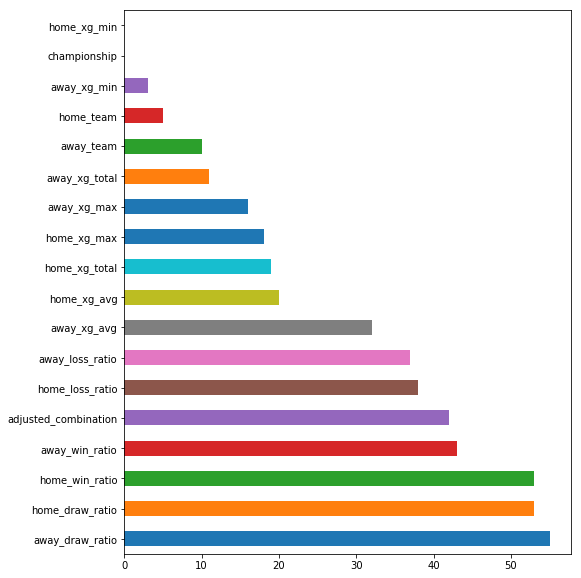

In [44]:
# plot feature importance
feat_imp = pd.Series(clf_final.feature_importances_, \
                     index=X_train.columns)
feat_imp.nlargest(20).plot(kind='barh', figsize=(8,10))

In [45]:
y_pred = clf_final.predict_proba(X_test, axis=1)

In [46]:
y_pred_1 = [np.argmax(line) for line in y_pred]

print("precision: ", precision_score(y_pred_1,y_test,average=None).mean(), \
      "\n", "accuracy: ", accuracy_score(y_pred_1,y_test))

precision:  0.43681072701834384 
 accuracy:  0.4753410283315845


# Task 2

In [47]:
train, test = task_2[0], task_2[1]

In [48]:
train.columns, test.columns

(Index(['date', 'championship', 'home_team', 'away_team', 'home_goals',
        'away_goals', 'home_shots', 'away_shots', 'result', 'away_win',
        'domestic_win', 'draw', 'target', 'adjusted_combination',
        'home_draw_ratio', 'home_loss_ratio', 'home_win_ratio', 'home_xg_avg',
        'home_xg_max', 'home_xg_min', 'home_xg_total', 'team_x',
        'away_draw_ratio', 'away_loss_ratio', 'away_win_ratio', 'away_xg_avg',
        'away_xg_max', 'away_xg_min', 'away_xg_total', 'team_y'],
       dtype='object'),
 Index(['date', 'championship', 'home_team', 'away_team', 'home_goals',
        'away_goals', 'home_shots', 'away_shots', 'result', 'away_win',
        'domestic_win', 'draw', 'target', 'adjusted_combination',
        'home_draw_ratio', 'home_loss_ratio', 'home_win_ratio', 'home_xg_avg',
        'home_xg_max', 'home_xg_min', 'home_xg_total', 'team_x',
        'away_draw_ratio', 'away_loss_ratio', 'away_win_ratio', 'away_xg_avg',
        'away_xg_max', 'away_xg_min', 'away_

In [49]:
del train["date"], train["home_goals"], train["away_goals"]\
, train["result"], train["away_win"], train["domestic_win"]\
, train["draw"], train["team_x"], train["team_y"] 

del test["date"], test["home_goals"], test["away_goals"]\
, test["result"], test["away_win"], test["domestic_win"]\
, test["draw"], test["team_x"], test["team_y"]

In [50]:
X_train, X_test = train, test
X_train["flag"] = 0
X_test["flag"] = 1
X = pd.concat([X_train, X_test], axis=0)
X = pd.get_dummies(X)
X_train = X[X["flag"] == 0]
X_test = X[X["flag"] == 1]
print(X_train.shape, X_test.shape)
y_train_1, y_train_2 = train["home_shots"], train["away_shots"]
y_test_1, y_test_2 = test["home_shots"], test["away_shots"]
del X_train["home_shots"], X_train["away_shots"], X_test["home_shots"], X_test["away_shots"]

(950, 1284) (953, 1284)


### Home_shots predicting

In [53]:
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
reg = GradientBoostingRegressor(**params)
reg.fit(X_train, y_train_1)
y_pred_1 = reg.predict(X_test)

In [54]:
print("mse: ", mean_squared_error(y_test_1, y_pred_1))

mse:  24.819331579477126


### Away_shots predicting

In [56]:
params = {'n_estimators': 1000, 'max_depth': 12, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
reg2 = GradientBoostingRegressor(**params)
reg2.fit(X_train, y_train_2)
y_pred_2 = reg2.predict(X_test)

In [57]:
print("mse: ", mean_squared_error(y_test_2, y_pred_2))

mse:  24.876875690402613
